In [146]:
import numpy as np
import matplotlib.pyplot as plt 

import pandas as pd  
import seaborn as sns

Importing Data

In [147]:
#adding dataset to the file

jazz_dataset = pd.read_csv("audio_features_df.csv", index_col=False)


In [148]:

# to drop any rows that are not useful in our analysis

jazz_dataset.drop(jazz_dataset[jazz_dataset['year_released'] == 0].index, inplace = True)

#changing all songs from before the 1940s to the 1940s to limit the number of categories
jazz_dataset.loc[jazz_dataset['year_released'] < 1940, 'year_released'] = 1940



In [149]:
#to get a standardized data set to use whenever we are running new models
#includes a boolean for when we want to have a multiclass (decades = True) or a binary classification
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#creating a method to initialize data
def scale_data(dataset, scalar = StandardScaler()):
    # prepare features 
    data = dataset.copy()
    target = []
    
    for year in data['year_released']:
        decade = int(str(year)[:2])
        if decade == 19:
            target.append(0)
        else:
            target.append(1)
    
    data = data.drop(['track_id','year_released'], axis=1)

    #scale features
    columns = data.columns
    scaled_features = scalar.fit_transform(data)
    scaled_dataset = pd.DataFrame(scaled_features, columns= columns)
    scaled_dataset['century'] = target

    return scaled_dataset



In [150]:
scaled_jazz_dataset_binary = scale_data(jazz_dataset)

scaled_jazz_dataset_binary.head()


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,timesig,popularity,duration_ms,century
0,1.034887,0.140746,1.395394,0.545107,0.850204,-0.381094,0.911636,-0.903755,0.608759,1.355119,0.415654,0.278752,0.559906,-0.797792,0
1,-2.601239,-1.268976,-0.325281,-2.437394,-1.176188,-0.426385,0.381263,0.787265,-0.656529,-1.828083,-1.099670,0.278752,-1.412387,0.373163,0
2,1.733129,0.365116,0.535056,0.466291,0.850204,-0.491605,-0.903283,-0.819344,-0.843979,1.048740,0.006604,0.278752,1.815002,-1.008741,0
3,-0.190329,-0.871037,0.535056,-1.032657,-1.176188,-0.361166,0.828861,-0.815162,-0.147736,-0.180705,-1.148881,0.278752,-1.950285,0.233358,0
4,-1.797602,-1.040372,-0.038502,-1.585397,0.850204,-0.393776,0.393526,-0.903760,-0.341881,-1.158762,-1.282775,0.278752,1.994301,-1.024123,0


Preliminary Data Exploration

distribution count for each century:
1900s: 10622
2000s: 9444


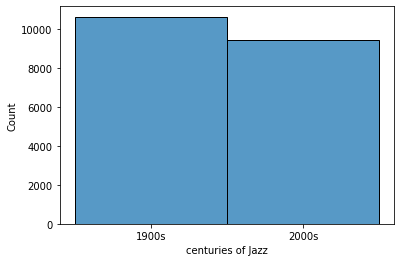

In [151]:
#to show the distribution of the centuries for our data exploration
import collections

centuries = []

for year in jazz_dataset['year_released']:
    century = str(int(str(year)[:2])) + '00s'
    centuries.append(century)

counter=collections.Counter(centuries)

print('distribution count for each century:')
for key in counter.items():
    print(f'{key[0]}: {key[1]}')
    

import seaborn as sns
x = pd.Series(centuries, name="centuries of Jazz")
ax = sns.histplot(data=x)


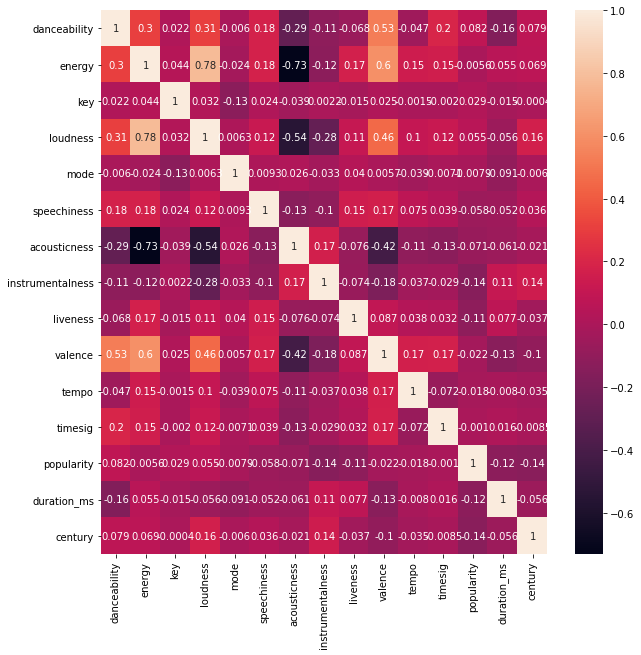

In [152]:
#to plot a correlation matrix
import matplotlib.pyplot as plt
import seaborn

fig, ax = plt.subplots(figsize=(10,10))
seaborn.heatmap(scaled_jazz_dataset_binary.corr(), annot=True, ax=ax)
plt.show()

In [153]:
#prepping data for modeling
from sklearn.model_selection import train_test_split
#1. data prep

#prepping features

x = scaled_jazz_dataset_binary.drop(['century'], axis=1)


#prepping target
y = scaled_jazz_dataset_binary['century']


#shuffling the dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, shuffle= True)


logistic regression model

In [154]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
# importing the necessary packages
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    mean_squared_error,
    accuracy_score,
    multilabel_confusion_matrix,
    plot_confusion_matrix,
    roc_auc_score,
    plot_roc_curve,
)

Testing Results:
--------------------------
Accuracy: 0.6597568267889177
Error: 0.34024317321108233
Precision: 0.6615104640582348
Recall: 0.6015721969383533
F1 Score: 0.6301191765980498
AUC: 0.7192170841157187

Training Results:
--------------------------
Accuracy: 0.6707422420094359
Error: 0.3292577579905641
Precision: 0.6574946792338097
Recall: 0.6154831364736019
F1 Score: 0.6357956633590592
AUC: 0.7289262376763317



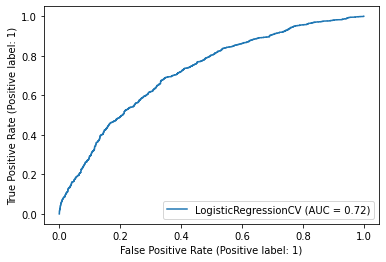

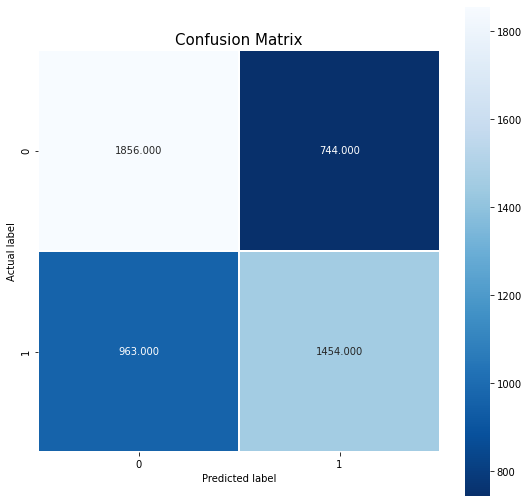

In [155]:
#to implement multi-class logistic regression w/ CV 

log_model = LogisticRegressionCV(cv = 5)

log_model.fit(x_train, y_train)

y_test_pred = log_model.predict(x_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_accuracy
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_F1_score = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, log_model.predict_proba(x_test)[:,1])

y_train_pred = log_model.predict(x_train)

train_accuracy = accuracy_score(y_train, y_train_pred)
train_error = (1 - train_accuracy)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_F1_score = f1_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, log_model.predict_proba(x_train)[:,1])


print(f"""Testing Results:
--------------------------
Accuracy: {test_accuracy}
Error: {test_error}
Precision: {test_precision}
Recall: {test_recall}
F1 Score: {test_F1_score}
AUC: {test_auc}
""")

print(f"""Training Results:
--------------------------
Accuracy: {train_accuracy}
Error: {train_error}
Precision: {train_precision}
Recall: {train_recall}
F1 Score: {train_F1_score}
AUC: {train_auc}
""")



# creating a confusion matrix
ax = plt.gca()
metrics.plot_roc_curve(log_model, x_test, y_test, ax=ax)


cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = f'Confusion Matrix'
plt.title(all_sample_title, size = 15);


k-nearst neighbors classifier

In [156]:
# training a KNN classifier
from sklearn.neighbors import KNeighborsClassifier

Testing Results:
--------------------------
Accuracy: 0.7550328881801873
Error: 0.24496711181981268
Precision: 0.7558139534883721
Recall: 0.7261067438973935
F1 Score: 0.74066258704368
AUC: 0.8322353680659432

Training Results:
--------------------------
Accuracy: 0.8408532128380624
Error: 0.15914678716193764
Precision: 0.8327586206896552
Recall: 0.82481855699445
F1 Score: 0.8287695717451921
AUC: 0.9292611232728893



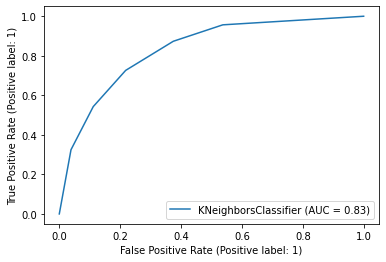

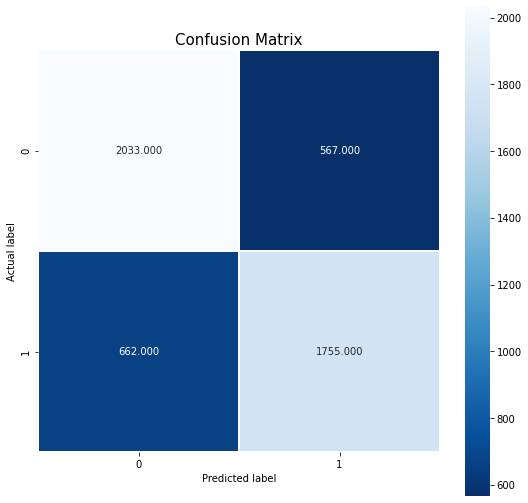

In [157]:
#model
knn_model = KNeighborsClassifier(n_neighbors = 5)

#fitting the model
knn_model.fit(x_train, y_train)

#to make predictions for the testing set
y_test_pred = knn_model.predict(x_test)

#to get metrics for the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_accuracy
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_F1_score = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, knn_model.predict_proba(x_test)[:,1])

#to make predictions for the training set
y_train_pred = knn_model.predict(x_train)

#to get metrics for the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_error = (1 - train_accuracy)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_F1_score = f1_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, knn_model.predict_proba(x_train)[:,1])


print(f"""Testing Results:
--------------------------
Accuracy: {test_accuracy}
Error: {test_error}
Precision: {test_precision}
Recall: {test_recall}
F1 Score: {test_F1_score}
AUC: {test_auc}
""")

print(f"""Training Results:
--------------------------
Accuracy: {train_accuracy}
Error: {train_error}
Precision: {train_precision}
Recall: {train_recall}
F1 Score: {train_F1_score}
AUC: {train_auc}
""")


# creating a confusion matrix
ax = plt.gca()
metrics.plot_roc_curve(knn_model, x_test, y_test, ax=ax)


cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = f'Confusion Matrix'
plt.title(all_sample_title, size = 15);


Naive Bayes Model

In [158]:

# training a naive bayes classifier
from sklearn.naive_bayes import GaussianNB

Testing Results:
--------------------------
Accuracy: 0.6352401833765199
Error: 0.3647598166234801
Precision: 0.6332274171584203
Recall: 0.5771617707902358
F1 Score: 0.6038961038961039
AUC: 0.6889292193119252

Training Results:
--------------------------
Accuracy: 0.6409728221144262
Error: 0.3590271778855738
Precision: 0.6399683844674897
Recall: 0.6409728221144262
F1 Score: 0.6395876531894321
AUC: 0.6982794078770929



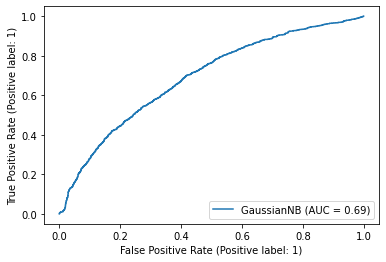

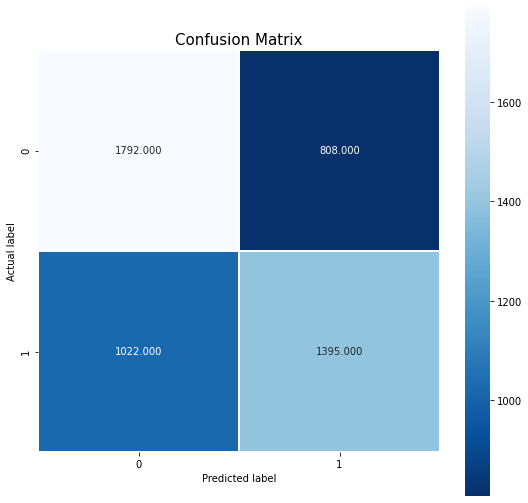

In [159]:

#instantiating the naive bayes model
nb_model = GaussianNB()

nb_model.fit(x_train, y_train)

#to make predictions for the testing set
y_test_pred = nb_model.predict(x_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_accuracy
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_F1_score = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, nb_model.predict_proba(x_test)[:,1])

#to make predictions for the training set
y_train_pred = nb_model.predict(x_train)

train_accuracy = accuracy_score(y_train, y_train_pred)
train_error = (1 - train_accuracy)
train_precision = precision_score(y_train, y_train_pred, average= 'weighted')
train_recall = recall_score(y_train, y_train_pred, average= 'weighted')
train_F1_score = f1_score(y_train, y_train_pred, average = 'weighted')
train_auc = roc_auc_score(y_train, nb_model.predict_proba(x_train)[:,1])


print(f"""Testing Results:
--------------------------
Accuracy: {test_accuracy}
Error: {test_error}
Precision: {test_precision}
Recall: {test_recall}
F1 Score: {test_F1_score}
AUC: {test_auc}
""")

print(f"""Training Results:
--------------------------
Accuracy: {train_accuracy}
Error: {train_error}
Precision: {train_precision}
Recall: {train_recall}
F1 Score: {train_F1_score}
AUC: {train_auc}
""")



# creating a confusion matrix
ax = plt.gca()
metrics.plot_roc_curve(nb_model, x_test, y_test, ax=ax)


cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = f'Confusion Matrix'
plt.title(all_sample_title, size = 15);


Adaboost classifier

In [160]:
from sklearn.ensemble import AdaBoostClassifier

Testing Results:
--------------------------
Accuracy: 0.7030097667929042
Error: 0.29699023320709583
Precision: 0.7079407806191117
Recall: 0.652875465453041
F1 Score: 0.6792940163581576
AUC: 0.7680407211737373

Training Results:
--------------------------
Accuracy: 0.721642634062064
Error: 0.27835736593793603
Precision: 0.714027149321267
Recall: 0.6736872064892557
F1 Score: 0.693270850113495
AUC: 0.7963701872646578



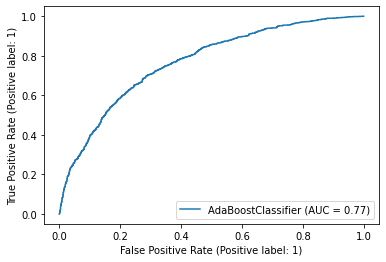

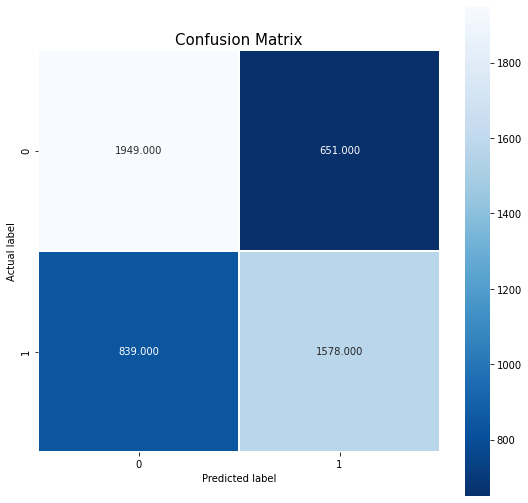

In [161]:
#to implement the adaboost ensemble classifier with 100 weak learners
adb_model = AdaBoostClassifier(n_estimators=100)

adb_model.fit(x_train, y_train)

#to make predictions for the testing set
y_test_pred = adb_model.predict(x_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_accuracy
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_F1_score = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, adb_model.predict_proba(x_test)[:,1])


#to make predictions for the training set
y_train_pred = adb_model.predict(x_train)

train_accuracy = accuracy_score(y_train, y_train_pred)
train_error = (1 - train_accuracy)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_F1_score = f1_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, adb_model.predict_proba(x_train)[:,1])


print(f"""Testing Results:
--------------------------
Accuracy: {test_accuracy}
Error: {test_error}
Precision: {test_precision}
Recall: {test_recall}
F1 Score: {test_F1_score}
AUC: {test_auc}
""")

print(f"""Training Results:
--------------------------
Accuracy: {train_accuracy}
Error: {train_error}
Precision: {train_precision}
Recall: {train_recall}
F1 Score: {train_F1_score}
AUC: {train_auc}
""")



# creating a confusion matrix
ax = plt.gca()
metrics.plot_roc_curve(adb_model, x_test, y_test, ax=ax)


cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = f'Confusion Matrix'
plt.title(all_sample_title, size = 15);


Random Forest Classifier

In [162]:
from sklearn.ensemble import RandomForestClassifier

Testing Results:
--------------------------
Accuracy: 0.861271676300578
Error: 0.138728323699422
Precision: 0.8539695598519128
Recall: 0.8589160115846091
F1 Score: 0.8564356435643565
AUC: 0.9442725406575221

Training Results:
--------------------------
Accuracy: 1.0
Error: 0.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
AUC: 1.0



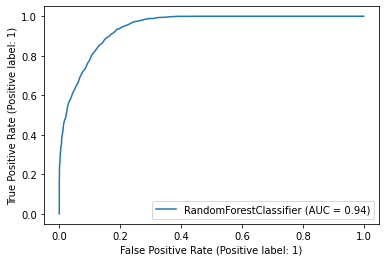

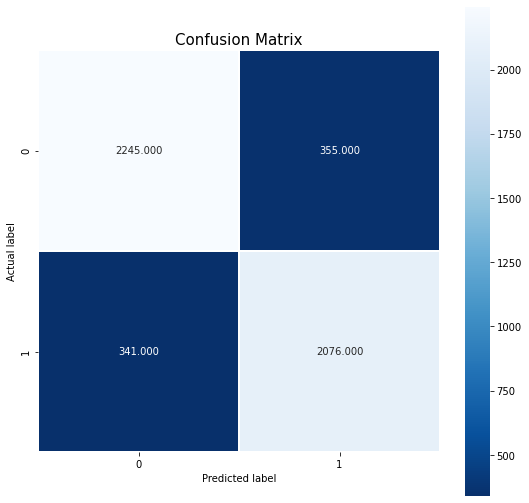

In [163]:
#to implement the adaboost ensemble classifier with 100 weak learners
rf_model = RandomForestClassifier(n_estimators=100)

rf_model.fit(x_train, y_train)

#to make predictions for the testing set
y_test_pred = rf_model.predict(x_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_accuracy
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_F1_score = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, rf_model.predict_proba(x_test)[:,1])


#to make predictions for the training set
y_train_pred = rf_model.predict(x_train)

train_accuracy = accuracy_score(y_train, y_train_pred)
train_error = (1 - train_accuracy)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_F1_score = f1_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, rf_model.predict_proba(x_train)[:,1])


print(f"""Testing Results:
--------------------------
Accuracy: {test_accuracy}
Error: {test_error}
Precision: {test_precision}
Recall: {test_recall}
F1 Score: {test_F1_score}
AUC: {test_auc}
""")

print(f"""Training Results:
--------------------------
Accuracy: {train_accuracy}
Error: {train_error}
Precision: {train_precision}
Recall: {train_recall}
F1 Score: {train_F1_score}
AUC: {train_auc}
""")



# creating a confusion matrix
ax = plt.gca()
metrics.plot_roc_curve(rf_model, x_test, y_test, ax=ax)


cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = f'Confusion Matrix'
plt.title(all_sample_title, size = 15);


Neural Network

In [164]:
nn_model = Sequential()

nn_model.add(Dense(8, activation='relu', input_shape=(14,)))

nn_model.add(Dense(8, activation='relu'))

nn_model.add(Dense(1, activation='sigmoid'))


nn_model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
                   
nn_model.fit(x_train, y_train,epochs=30, batch_size=64, verbose=1)

Epoch 1/30
236/236 [==============================] - 1s 2ms/step - loss: 0.7060 - accuracy: 0.5057
Epoch 2/30
236/236 [==============================] - 0s 1ms/step - loss: 0.6936 - accuracy: 0.5244
Epoch 3/30
236/236 [==============================] - 0s 1ms/step - loss: 0.6858 - accuracy: 0.5393
Epoch 4/30
236/236 [==============================] - 0s 1ms/step - loss: 0.6817 - accuracy: 0.5489
Epoch 5/30
236/236 [==============================] - 0s 1ms/step - loss: 0.6781 - accuracy: 0.5572
Epoch 6/30
236/236 [==============================] - 0s 1ms/step - loss: 0.6721 - accuracy: 0.5659
Epoch 7/30
236/236 [==============================] - 0s 1ms/step - loss: 0.6661 - accuracy: 0.5876
Epoch 8/30
236/236 [==============================] - 0s 2ms/step - loss: 0.6619 - accuracy: 0.5951
Epoch 9/30
236/236 [==============================] - 0s 1ms/step - loss: 0.6539 - accuracy: 0.6104
Epoch 10/30
236/236 [==============================] - 0s 1ms/step - loss: 0.6480 - accuracy: 0.6140

Testing Results:
--------------------------
Accuracy: 0.6669324297388878
Error: 0.3330675702611122
Precision: 0.6646072374227714
Recall: 0.6230864708316094
F1 Score: 0.6431774503523381
AUC: 0.7334462620540404

Training Results:
--------------------------
Accuracy: 0.6807096817064257
Error: 0.31929031829357435
Precision: 0.6645925925925926
Recall: 0.638394763056781
F1 Score: 0.6512303113885461
AUC: 0.7452247620452607



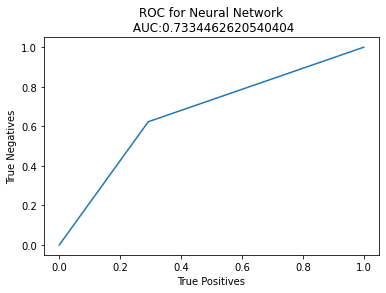

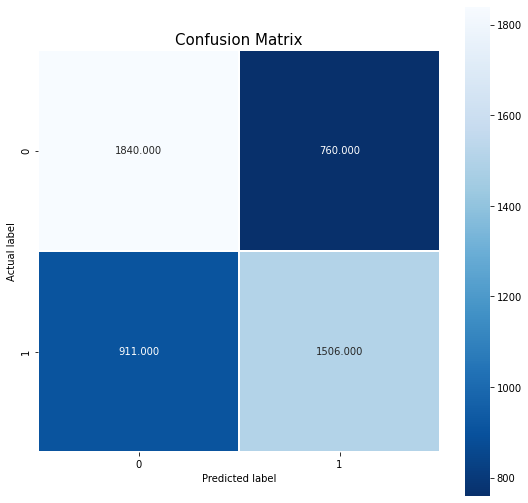

In [165]:

#to make predictions for the testing set
y_test_pred = (nn_model.predict(x_test) > 0.5).astype("int32")


test_accuracy = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_accuracy
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_F1_score = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, nn_model.predict(x_test).ravel())


#to make predictions for the training set
y_train_pred = (nn_model.predict(x_train) > 0.5).astype("int32")

train_accuracy = accuracy_score(y_train, y_train_pred)
train_error = (1 - train_accuracy)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_F1_score = f1_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, nn_model.predict(x_train).ravel())


print(f"""Testing Results:
--------------------------
Accuracy: {test_accuracy}
Error: {test_error}
Precision: {test_precision}
Recall: {test_recall}
F1 Score: {test_F1_score}
AUC: {test_auc}
""")

print(f"""Training Results:
--------------------------
Accuracy: {train_accuracy}
Error: {train_error}
Precision: {train_precision}
Recall: {train_recall}
F1 Score: {train_F1_score}
AUC: {train_auc}
""")

from sklearn.metrics import roc_curve

# creating a confusion matrix
nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test, y_test_pred)
plt.plot(nn_fpr_keras, nn_tpr_keras)
plt.title(f"ROC for Neural Network\n AUC:{test_auc}")
plt.xlabel("True Positives")
plt.ylabel("True Negatives")



cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = f'Confusion Matrix'
plt.title(all_sample_title, size = 15);
